In [1]:
%pylab inline
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import seaborn as sea
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Importación y procesamiento de datos

In [2]:
data= pd.DataFrame(pd.read_csv("wine.data", header = None))
data.columns = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
target = data["Class"]
del data["Class"]
scaled_data = preprocessing.scale(data) #Desviacion estandar = 1 y promedio = 0

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, target)

#K-means clustering 

In [4]:
from sklearn.cluster import KMeans

##Optimización de parámetros del modelo

In [5]:
errors_km = np.zeros(10)
for i in range(1,11):
    fit_K  = KMeans(n_clusters = i).fit(X_train, Y_train)
    errors_km[i-1] = fit_K.inertia_    

El error en este caso se define como la distancia total que hay entre los todos los puntos y el centro del cluster más cercano 

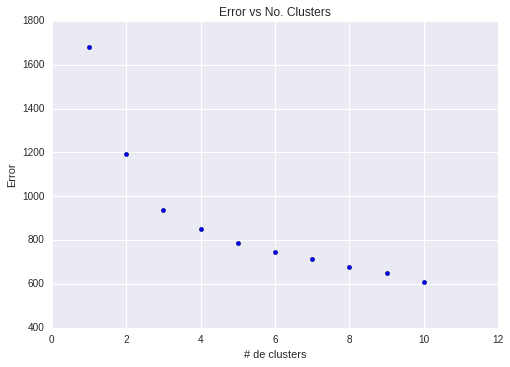

In [6]:
x = linspace(1, 10, 10)
scatter(x, errors_km)
title("Error vs No. Clusters")
xlabel("# de clusters")
ylabel("Error")

Se puede ver que al llegar a tres clusters el error se satura y por cada cluster extra el error disminuye en menos medida. Es por esto que el número óptimo de clusters para usar en estos datos es tres.

##Clasificación

In [7]:
km = KMeans(n_clusters = 3)
fit = km.fit(X_train, Y_train)
predict_km = km.predict(X_test)

##Validación de KMeans Clustering

Teniendo en cuenta que la predicción de kmeans consiste en agrupar los puntos al cluster más cercano, no se puede hacer una comparación directa entre los labels dados por la función predict() y el target del dataset. Es por esto que para encontrar qué proporción de puntos fue clasificado correctamente se mostrarán gráficas en las que se podrán ver cuántos puntos fueron clasificados de manera incorrecta. De esta forma se determinarán qué número de cluster corresponde a la clase de vino para realizar una comparación apropiada de las clasificaciones.

In [8]:
index_km = Y_test.index.values
results_km = pd.concat([Y_test, pd.DataFrame(data =predict_km, index = index_km, columns = ["Cluster"])], axis=1)

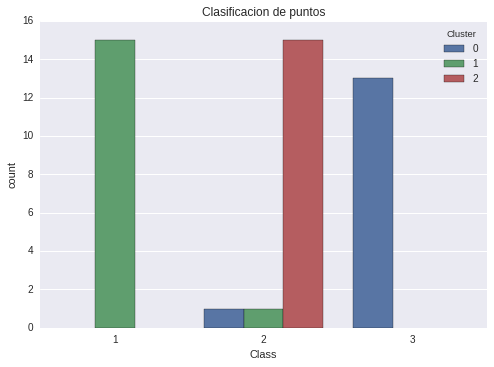

In [9]:
sea.countplot(x= "Class", hue = "Cluster", data= results_km)
title("Clasificacion de puntos")

En la gráfica se puede ver cuántos puntos se clasificaron incorrectamente.

In [10]:
grouped_km = results_km.groupby(["Class"])
class1 = grouped_km.get_group(1)
class2 = grouped_km.get_group(2)
class3 = grouped_km.get_group(3)

In [11]:
cluster_label1 = class1['Cluster'].value_counts().idxmax()
cluster_label2 = class2['Cluster'].value_counts().idxmax()
cluster_label3 = class3['Cluster'].value_counts().idxmax()

In [12]:
err_km = 0
for i in range(len(class1)):
    if class1["Cluster"].iloc[i] != cluster_label1:
        err_km += 1
for i in range(len(class2)):
    if class2["Cluster"].iloc[i] != cluster_label2:
        err_km += 1
for i in range(len(class3)):
    if class3["Cluster"].iloc[i] != cluster_label3:
        err_km += 1     
eff_km = float(len(predict_km) - err_km)/float(len(predict_km))
print("Eficiencia KMeans clustering:{0:.2f}%".format(eff_km*100))

Eficiencia KMeans clustering:95.56%


#Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

##Optimización de parámetros del modelo

In [14]:
n_trees_total = 100
error_rf = np.zeros(n_trees_total)
m = 3 #Se toma como el numero de predictores como sqrt(p)
for i in range(1,n_trees_total+1):
    rf_test = RandomForestClassifier(n_estimators = i, max_features =  m)
    rf_test.fit(X_train, Y_train)
    predict_rf_test = rf_test.predict(X_test)
    good_class_rf = 0
    for j in range(len(predict_rf_test)):
        if predict_rf_test[j] == Y_test.iloc[j]:
            good_class_rf += 1
    error_rf[i-1] = 1- float(good_class_rf)/float(len(predict_rf_test))


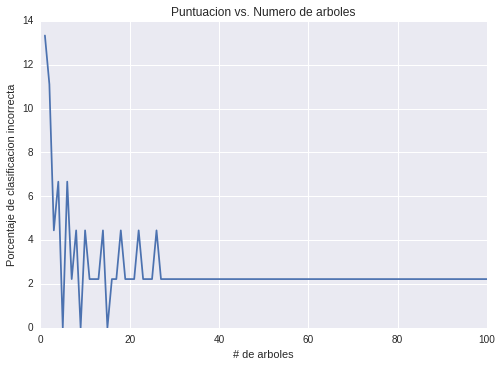

In [15]:
x = range(1, n_trees_total+1)
plot(x, error_rf*100)
title("Puntuacion vs. Numero de arboles")
xlabel("# de arboles")
ylabel("Porcentaje de clasificacion incorrecta")

En la gráfica se observa que a partir de 40 árboles se logra un porcentaje constante de puntos clasficados incorrectamente. Este comportamiento no se dio de manera tan uniforme en todos los casos pero sí se observó que a partir de 50 árboles el porcentaje de error tendía a mantenerse constante.

##Clasificación

In [22]:
rf = RandomForestClassifier(n_estimators=50, max_features=3)
fit_rf = rf.fit(X_train, Y_train) 
predict_rf = rf.predict(X_test)

##Validación RandomForestClassifier

In [23]:
good_class_rf = 0
for i in range(len(predict_rf)):
    if predict_rf[i] == Y_test.iloc[i]:
        good_class_rf += 1
eff_rf = float(good_class_rf)/float(len(predict_rf))
print("Eficiencia Random Forest:{0:.2f}%".format(eff_rf*100))

Eficiencia Random Forest:97.78%


#SVM

In [40]:
from sklearn import svm

##Optimización de parámetros

In [41]:
gamma_range = logspace(-2, 2, 20)
c_range = linspace(1,10,10)
param_grid_svm= {'gamma': gamma_range, 'C':c_range}
cv = ShuffleSplit(len(target), n_iter=10, test_size=0.1)
grid_svm = GridSearchCV(svm.SVC(), param_grid=param_grid_svm, cv=cv)
grid_svm.fit(scaled_data,target)

GridSearchCV(cv=ShuffleSplit(178, n_iter=10, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]), 'gamma': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
best_C = grid_svm.best_params_['C']
best_gamma = grid_svm.best_params_['gamma']

##Clasificación

In [43]:
svm = svm.SVC(C=best_C, gamma = best_gamma, kernel = 'rbf') 
fit_svm = svm.fit(X_train, Y_train)
predict_svm = svm.predict(X_test)

##Validación SVM Classifier

In [44]:
good_class_svm = 0
for i in range(len(predict_svm)):
    if predict_svm[i] == Y_test.iloc[i]:
        good_class_svm += 1
eff_svm = float(good_class_svm)/float(len(predict_svm))
print("Eficiencia Support Vector Machine Classifier:{0:.2f}%".format(eff_svm*100))

Eficiencia Support Vector Machine Classifier:97.78%


#PCA

In [27]:
from sklearn.decomposition import PCA

##Optimización de parámetros del modelo

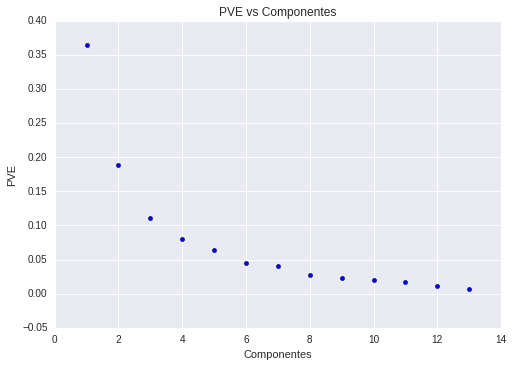

In [28]:
fit_PCA_test = PCA().fit(X_train, Y_train)
PVE = fit_PCA_test.explained_variance_ratio_
scatter(range(1,14),PVE)
title("PVE vs Componentes")
xlabel("Componentes")
ylabel("PVE")

En la gráfica se puede ver que a partir de la 4 componente el PVE comienza a saturarse. Es por esto que el número óptimo de componentes para reducir el set de datos es 4.

##Reducción dimensionalidad usando PCA

In [29]:
fit_PCA = PCA(n_components = 4)
fit_PCA.fit(scaled_data)
PCA_result = fit_PCA.transform(scaled_data)

In [30]:
scaled_PCA = preprocessing.scale(PCA_result)
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(scaled_PCA, target)

Es importante anotar que no se puede usar únicamente PCA para clasificación. Es por esto que se usará una reducción de dimensiones usando PCA y después se clasificará usando KMeans clustering y Random Forests

##Clasificación usando KMeans clustering y PCA

In [31]:
km_pca = KMeans(n_clusters = 3)
fit_pca_km = km.fit(X_train_pca, Y_train_pca)
predict_km_pca = km.predict(X_test_pca)

##Validación de PCA con KMeans clustering

In [32]:
index_km_pca = Y_test_pca.index.values
results_km_pca = pd.concat([Y_test_pca, pd.DataFrame(data =predict_km_pca, index = index_km_pca, columns = ["Cluster"])], axis=1)

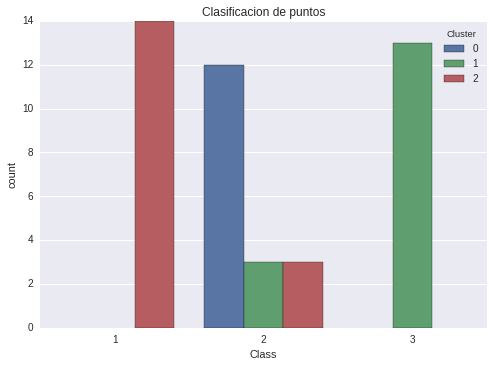

In [33]:
sea.countplot(x= "Class", hue = "Cluster", data= results_km_pca)
title("Clasificacion de puntos")

In [34]:
grouped_km_pca = results_km_pca.groupby(["Class"])
class1_pca = grouped_km_pca.get_group(1)
class2_pca = grouped_km_pca.get_group(2)
class3_pca = grouped_km_pca.get_group(3)

In [35]:
pcacluster_label1 = class1_pca['Cluster'].value_counts().idxmax()
pcacluster_label2 = class2_pca['Cluster'].value_counts().idxmax()
pcacluster_label3 = class3_pca['Cluster'].value_counts().idxmax()

In [36]:
err_km_pca = 0
for i in range(len(class1_pca)):
    if class1_pca["Cluster"].iloc[i] != pcacluster_label1:
        err_km_pca += 1
for i in range(len(class2_pca)):
    if class2_pca["Cluster"].iloc[i] != pcacluster_label2:
        err_km_pca += 1
for i in range(len(class3_pca)):
    if class3_pca["Cluster"].iloc[i] != pcacluster_label3:
        err_km_pca += 1     
eff_km_pca = float(len(predict_km_pca) - err_km_pca)/float(len(predict_km_pca))
print("Eficiencia KMeans clustering con PCA:{0:.2f}%".format(eff_km_pca*100))

Eficiencia KMeans clustering con PCA:86.67%


##Clasificación usando Random Forest y PCA

In [45]:
rf_pca = RandomForestClassifier(n_estimators=50, max_features=3)
fit_rf_pca = rf_pca.fit(X_train, Y_train) 
predict_rf_pca = rf_pca.predict(X_test)

##Validación de Random Forest usando PCA

In [46]:
good_class_rf_pca = 0
for i in range(len(predict_rf_pca)):
    if predict_rf_pca[i] == Y_test.iloc[i]:
        good_class_rf_pca += 1
eff_rf_pca = float(good_class_rf_pca)/float(len(predict_rf_pca))
print("Eficiencia Random Forest:{0:.2f}%".format(eff_rf_pca*100))

Eficiencia Random Forest:97.78%


#Resultados

Los resultados obtenidos para este set de datos son que los mejores modelos de clasificación son SVM Classifier, Random Forest Classifier y Random Forest Classifier con PCA. Estos tres métodos lograron en algunas ocasiones clasificar con éxito todos los puntos del set de prueba. Además, el máximo error que presentaron estos tres modelos fue clasificar de forma errónea un punto. El que le sigue a estos tres modelo es KMeans clustering, ya que nunca logró una clasificación perfecta pero el error nunca sobrepasó los dos puntos clasificados incorrectamente. Por último, el modelo que mostró peor desempeño fue KMeans clustering con PCA, porque en las pruebas realizadas siempre clasificó con éxito menos puntos que los otros cuatro modelos.